In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn

In [31]:
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


In [45]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from evaluate import evaluate
from unet import UNet
from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss

ModuleNotFoundError: No module named 'wandb'

In [7]:
path="Data/"

In [8]:
os.listdir(path)

['.DS_Store',
 'README.md',
 'TCGA_CS_4941_19960909',
 'TCGA_CS_4942_19970222',
 'TCGA_CS_4943_20000902',
 'TCGA_CS_4944_20010208',
 'TCGA_CS_5393_19990606',
 'TCGA_CS_5395_19981004',
 'TCGA_CS_5396_20010302',
 'TCGA_CS_5397_20010315',
 'TCGA_CS_6186_20000601',
 'TCGA_CS_6188_20010812',
 'TCGA_CS_6290_20000917',
 'TCGA_CS_6665_20010817',
 'TCGA_CS_6666_20011109',
 'TCGA_CS_6667_20011105',
 'TCGA_CS_6668_20011025',
 'TCGA_CS_6669_20020102',
 'TCGA_DU_5849_19950405',
 'TCGA_DU_5851_19950428',
 'TCGA_DU_5852_19950709',
 'TCGA_DU_5853_19950823',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_5855_19951217',
 'TCGA_DU_5871_19941206',
 'TCGA_DU_5872_19950223',
 'TCGA_DU_5874_19950510',
 'TCGA_DU_6399_19830416',
 'TCGA_DU_6400_19830518',
 'TCGA_DU_6401_19831001',
 'TCGA_DU_6404_19850629',
 'TCGA_DU_6405_19851005',
 'TCGA_DU_6407_19860514',
 'TCGA_DU_6408_19860521',
 'TCGA_DU_7008_19830723',
 'TCGA_DU_7010_19860307',
 'TCGA_DU_7013_19860523',
 'TCGA_DU_7014_19860618',
 'TCGA_DU_7018_19911220',
 'TCGA_DU_

In [24]:
training_data=[]
def dataset():
    for directory in os.listdir(path):
        for img in os.listdir(os.path.join(path,directory)):
            if 'mask' not in os.path.basename(img):
                img_array=cv2.imread(os.path.join(path,directory,img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                training_data.append(img_array)
                print(os.path.basename(img))
dataset()

TCGA_CS_4941_19960909_1.tif
TCGA_CS_4941_19960909_10.tif
TCGA_CS_4941_19960909_11.tif
TCGA_CS_4941_19960909_12.tif
TCGA_CS_4941_19960909_13.tif
TCGA_CS_4941_19960909_14.tif
TCGA_CS_4941_19960909_15.tif
TCGA_CS_4941_19960909_16.tif
TCGA_CS_4941_19960909_17.tif
TCGA_CS_4941_19960909_18.tif
TCGA_CS_4941_19960909_19.tif
TCGA_CS_4941_19960909_2.tif
TCGA_CS_4941_19960909_20.tif
TCGA_CS_4941_19960909_21.tif
TCGA_CS_4941_19960909_22.tif
TCGA_CS_4941_19960909_23.tif
TCGA_CS_4941_19960909_3.tif
TCGA_CS_4941_19960909_4.tif
TCGA_CS_4941_19960909_5.tif
TCGA_CS_4941_19960909_6.tif
TCGA_CS_4941_19960909_7.tif
TCGA_CS_4941_19960909_8.tif
TCGA_CS_4941_19960909_9.tif
TCGA_CS_4942_19970222_1.tif
TCGA_CS_4942_19970222_10.tif
TCGA_CS_4942_19970222_11.tif
TCGA_CS_4942_19970222_12.tif
TCGA_CS_4942_19970222_13.tif
TCGA_CS_4942_19970222_14.tif
TCGA_CS_4942_19970222_15.tif
TCGA_CS_4942_19970222_16.tif
TCGA_CS_4942_19970222_17.tif
TCGA_CS_4942_19970222_18.tif
TCGA_CS_4942_19970222_19.tif
TCGA_CS_4942_19970222_2.

In [34]:
type(training_data)

list

In [40]:
n_val = int(len(training_data) * 0.20)
n_train = len(training_data) - n_val
train_set, val_set = random_split(training_data, [n_train, n_val], generator=torch.Generator().manual_seed(0))

In [41]:
loader_args = dict(batch_size=32, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [38]:
type(val_set)

torch.utils.data.dataset.Subset

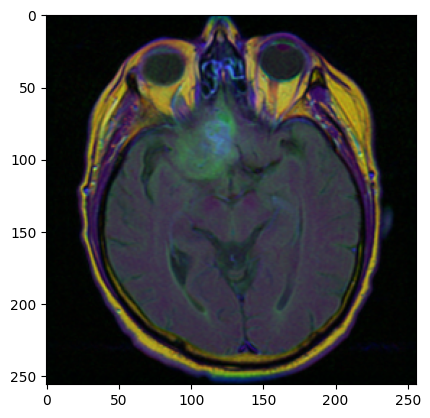

In [27]:
plt.imshow(training_data[2])

In [29]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [54]:
model=UNet
optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0

NameError: name 'self' is not defined

In [ ]:
epochs= 5
batch_size= 1
learning_rate= 1e-5
val_percent= 0.1
save_checkpoint = True
img_scale= 0.5
amp= False
weight_decay= 1e-8
momentum = 0.999
gradient_clipping= 1.0

In [46]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                



In [49]:
def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()

In [50]:
args=get_args()
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
                f'\t{model.n_channels} input channels\n'
                f'\t{model.n_classes} output channels (classes)\n'
                f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp
    )

usage: ipykernel_launcher.py [-h] [--epochs E] [--batch-size B]
                             [--learning-rate LR] [--load LOAD]
                             [--scale SCALE] [--validation VAL] [--amp]
                             [--bilinear] [--classes CLASSES]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\prabh\AppData\Roaming\jupyter\runtime\kernel-v346386be63fd4f46fee7b12ee57de2161697ea62f.json


SystemExit: 2

c:\Users\prabh\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
